## Function Transformation?

Function Transformation is a technique to **apply mathematical functions to features** in a dataset to:

- Reduce skewness
- Stabilize variance
- Improve model performance (especially linear models)

In **scikit-learn**, we use `FunctionTransformer` to apply any function (like `log`, `sqrt`) as part of a pipeline.

---

## Why Apply Transformations?

- Linear models (Logistic Regression, Linear Regression, SVM) perform better if features are **more normal-like**.
- Tree-based models (Decision Tree, Random Forest) are **less sensitive**, but transformations can still help with extreme outliers.
- Helps models converge faster and produce better predictions.

| Transformation | When to Use | Example |
|----------------|------------|---------|
| `log(x)` / `np.log1p(x)` | Right-skewed, positive values | Fare, Income |
| `sqrt(x)` / `np.sqrt(x)` | Moderate skew, counts | Age, Visits |
| `reciprocal` / `1/x` | Strong right skew, ratios | Speed, Density |

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [4]:
df.isnull().sum()

Survived      0
Age         177
Fare          0
dtype: int64

In [5]:

df['Age'] = df['Age'].fillna(df['Age'].mean())

df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [6]:
import scipy.stats as stats

scipy.stats is commonly used for:

1) Checking normality
2) Feature distribution analysis
3) Hypothesis testing
4) Statistical validation of results
\
   SciPy is a scientific computing library built on top of NumPy.

In [8]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,1:3]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

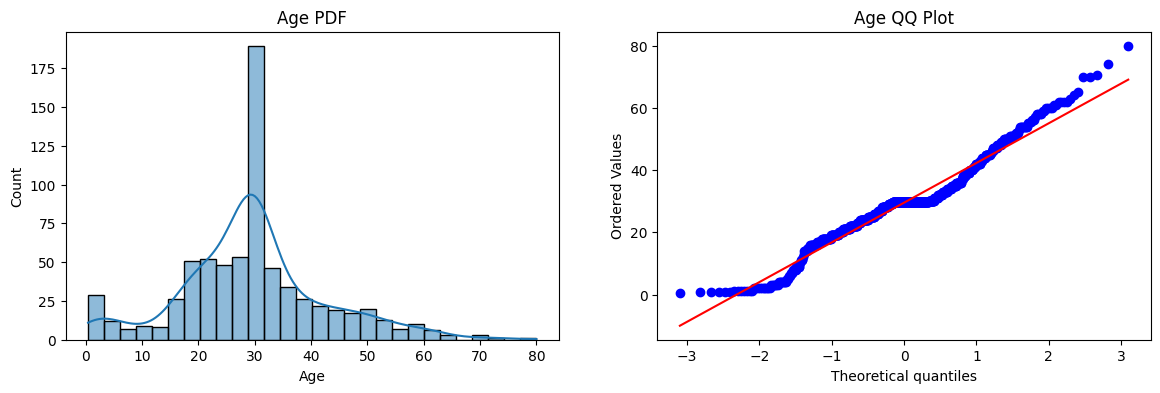

In [9]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.histplot(X_train['Age'],kde=True)
plt.title('Age PDF')

plt.subplot(122)
stats.probplot(X_train['Age'], dist="norm", plot=plt)
plt.title('Age QQ Plot')

plt.show()

Using SciPy:
\
This creates a Q-Q plot (Quantile–Quantile plot) to check if data follows a normal distribution.
\
If your data is normally distributed → Points will lie approximately on a straight line.
\
\
✅ If points follow straight line:

Data is approximately normal.

📉 If points curve upward:

Right skewed.

📈 If points curve downward:

Left skewed.

🔺 If ends deviate strongly:

Heavy tails / Outliers present.

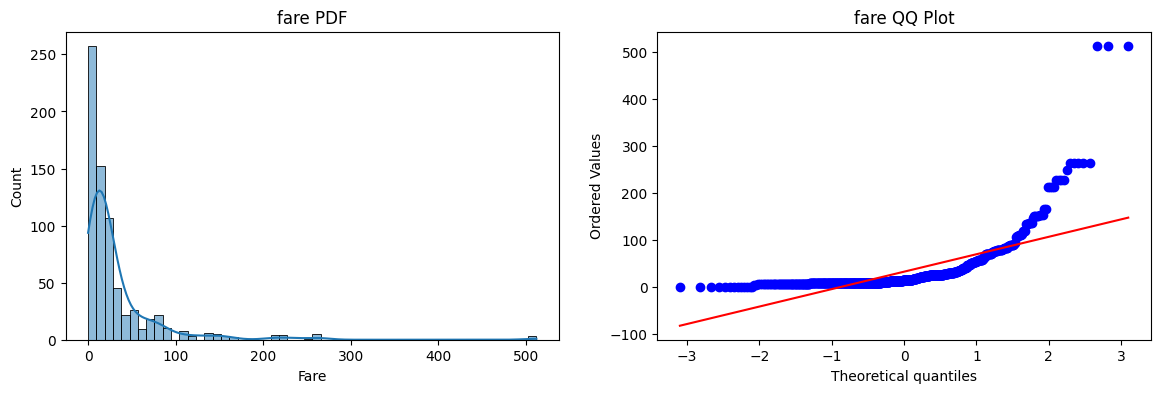

In [31]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.histplot(X_train['Fare'],kde=True)
plt.title('fare PDF')

plt.subplot(122)
stats.probplot(X_train['Fare'], dist="norm", plot=plt)
plt.title('fare QQ Plot')

plt.show()

# Log Transformation (np.log1p)
\
Use When:
1) Data is right-skewed
2) Long tail on the right
3) Values are positive
4) Large outliers exist

Don’t Use When:

1) Data is already normally distributed
2) Data has negative values


**Syntax** :- **FunctionTransformer(np.log1p)**



# Square Root Transformation (np.sqrt)
\
Use When:

1) Moderately right-skewed data
2) Less extreme skew
3) Count-based data

**Syntax** :- **FunctionTransformer(np.sqrt)**

# Reciprocal Transformation (1/x)

Use When:

1) Strong right skew
2) Large values dominate
3) Relationship is hyperbolic

Be Careful:

1) Cannot contain zero values
2) Sensitive to small numbers

**Syntax** :- **FunctionTransformer(lambda x: 1/x)**

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer


**Logistic Regression (without transformation)**

In [12]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

**Decision Tree (without transformation)**

In [13]:
clf2 = DecisionTreeClassifier()
clf2.fit(X_train,y_train)
y_pred1 = clf2.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score
print("Accuracy LR",accuracy_score(y_test,y_pred))
print("Accuracy DT",accuracy_score(y_test,y_pred1))

Accuracy LR 0.6480446927374302
Accuracy DT 0.664804469273743


**Logistic Regression (with log transformation on Fare)**

In [16]:
log_fare = FunctionTransformer(np.log1p, validate=True)

In [25]:
preprocess = ColumnTransformer([
    ("fare_log", log_fare, ['Fare'])
])
# Pipeline with logistic regression
from sklearn.pipeline import Pipeline
model = Pipeline([
    ("preprocessing", preprocess),
    ("classifier", LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)
y_pred2 = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred2))

Accuracy: 0.6815642458100558


In [27]:

# Pipeline with Decision Tree
from sklearn.pipeline import Pipeline
model2 = Pipeline([
    ("preprocessing", preprocess),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

model2.fit(X_train, y_train)
y_pred3 = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred3))

Accuracy: 0.6815642458100558


(without transformation)  **Logistic Regression	== 0.648**\
(with log transformation) **Logistic Regression + Log(Fare) == 0.68**

**Fare was right-skewed. Log transformation reduced skewness and made the relationship between feature and target more linear, which benefits Logistic Regression.**

In [21]:

age_sqrt = FunctionTransformer(np.sqrt, validate=True)  # sqrt on Age
fare_log = FunctionTransformer(np.log1p, validate=True) # log on Fare

preprocess = ColumnTransformer([
    ("age_sqrt", age_sqrt, ['Age']),
    ("fare_log", fare_log, ['Fare'])
])

# --- Logistic Regression Pipeline ---
lr_model = Pipeline([
    ("preprocessing", preprocess),
    ("classifier", LogisticRegression(max_iter=1000))
])

lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Accuracy Logistic Regression:", accuracy_score(y_test, y_pred_lr))

# --- Decision Tree Pipeline ---
dt_model = Pipeline([
    ("preprocessing", preprocess),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Accuracy Decision Tree:", accuracy_score(y_test, y_pred_dt))

Accuracy Logistic Regression: 0.6703910614525139
Accuracy Decision Tree: 0.664804469273743


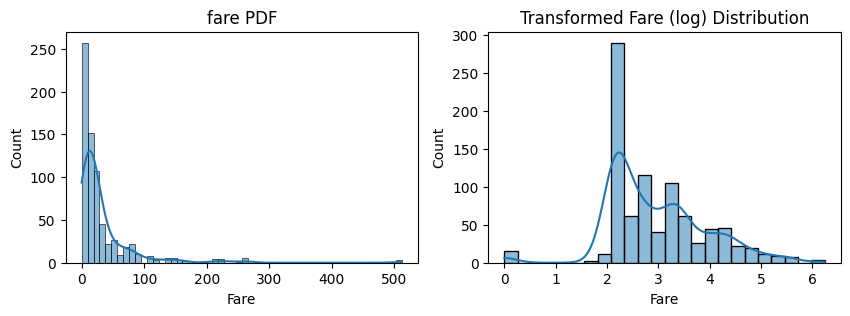

In [37]:
fare_transformed = np.log1p(df['Fare'])
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
sns.histplot(X_train['Fare'],kde=True)
plt.title('fare PDF')

plt.subplot(1,2,2)
sns.histplot(fare_transformed, kde=True)
plt.title('Transformed Fare (log) Distribution')
plt.show()

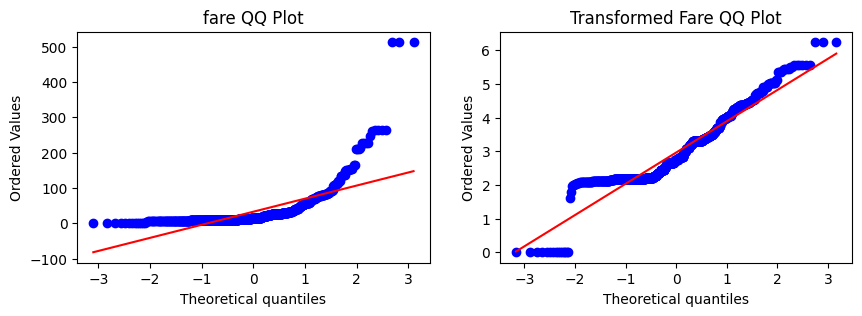

In [39]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
stats.probplot(X_train['Fare'], dist="norm", plot=plt)
plt.title('fare QQ Plot')

plt.subplot(1,2,2)
stats.probplot(fare_transformed, dist="norm", plot=plt)
plt.title('Transformed Fare QQ Plot')
plt.show()

- Logistic Regression improves significantly after transforming Fare (log) and Age (sqrt).
- Decision Trees show smaller improvement because they are insensitive to feature distributions.
- Feature transformation is a powerful tool for pre-processing and improving linear model performance.